In [3]:

try:
  import pandas as pd
  import numpy as np
  import os
  import joblib
  import lightgbm as lgb
  import matplotlib.pyplot as plt
  import seaborn as sns
  from lightgbm import early_stopping

  from sklearn.model_selection import train_test_split
  from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
  from tqdm import tqdm
except Exception as e:
  print(e)

In [7]:
df = pd.read_csv(r"D:\Supply-Chain-FYP\Machine_learing_model\train (1).csv")

In [8]:
df.head(1)

,date,store,item,sales
0,2013-01-01,1,1,13


## Pre Processing 

In [9]:
# Pre-processing
def load_and_preprocess(df):

    df['date'] = pd.to_datetime(df['date'])
    df['sales'] = df['sales'].fillna(0)
    df = df.sort_values(by=['store', 'item', 'date']).reset_index(drop=True)
    return df

## Feature Engineering

In [10]:
# Feature Engineering
def add_sales_timeseries_metrics(df):
    df['sales_1_day_ago'] = df.groupby(['store', 'item'])['sales'].shift(1)
    df['sales_7_days_ago'] = df.groupby(['store', 'item'])['sales'].shift(7)
    df['rolling_14_day_sales'] = df.groupby(['store', 'item'])['sales'].rolling(window=14, min_periods=1).sum().reset_index(drop=True)
    df['rolling_28_day_sales'] = df.groupby(['store', 'item'])['sales'].rolling(window=28, min_periods=1).sum().reset_index(drop=True)
    df['mean_sales'] = df.groupby(['store', 'item'])['sales'].expanding().mean().reset_index(drop=True)
    return df

def add_date_features(df):
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['day_of_week'] = df['date'].dt.weekday
    df['weekend'] = (df['day_of_week'] >= 5).astype(int)
    df['quarter'] = df['date'].dt.quarter
    return df


## Target Variables

In [11]:
# Target variables
def create_targets(df):
    df['target_7_day_sales'] = df.groupby(['store', 'item'])['sales'].shift(-1).rolling(window=7, min_periods=1).sum().reset_index(drop=True)
    df['target_30_day_sales'] = df.groupby(['store', 'item'])['sales'].shift(-1).rolling(window=30, min_periods=1).sum().reset_index(drop=True)
    return df

## Training model function 

In [13]:
def train_models(df, target_col, model_dir='ml_models/models_7'):
    os.makedirs(model_dir, exist_ok=True)
    df = load_and_preprocess(df)
    # df = preprocess_dataframe(df)
    df = add_sales_timeseries_metrics(df)
    df = add_date_features(df)
    df = create_targets(df)

    features = [
        'sales_1_day_ago', 'sales_7_days_ago', 'rolling_14_day_sales',
        'rolling_28_day_sales', 'mean_sales', 'day', 'month', 'year',
        'day_of_week', 'weekend', 'quarter'
    ]

    df = df.dropna(subset=features + [target_col])
    items = df['item'].unique()
    stores = df['store'].unique()

    scores = []

    for item_id in tqdm(items, desc="Items"):
        for store_id in stores:
            df_is = df[(df['item'] == item_id) & (df['store'] == store_id)].copy()

            if df_is.shape[0] < 60:
                continue  # skip too small series

            X = df_is[features]
            y = df_is[target_col]

            X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, shuffle=False)

            model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.01)
            model.fit(X_train, y_train,eval_set=[(X_val, y_val)],callbacks=[early_stopping(stopping_rounds=100)])

            y_pred = model.predict(X_val)
            rmse = np.sqrt(mean_squared_error(y_val, y_pred))
            mae = mean_absolute_error(y_val, y_pred)
            r2 = r2_score(y_val, y_pred)

            scores.append({
                'store': store_id, 'item': item_id,
                'RMSE': rmse, 'MAE': mae, 'R2': r2
            })

            model_name = f"{store_id}_{item_id}_{target_col}.pkl"
            joblib.dump(model, os.path.join(model_dir, model_name))

    return pd.DataFrame(scores)


## Training on 7 days 

In [15]:
# Train models for both 7 and 30 day forecasts
try:
  scores_7 = train_models(df.copy(), target_col='target_7_day_sales', model_dir='ml_models/models_7')
except Exception as e:
  print(e)

Items:   0%|          | 0/50 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 889
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 137.448381
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[356]	valid_0's l2: 129.389
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 917
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 193.414172
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[758]	valid_0's l2: 258.786
[L

Items:   2%|▏         | 1/50 [00:10<08:57, 10.96s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 983
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 364.904704
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[566]	valid_0's l2: 585.93
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1016
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 518.244349
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[543]	valid_0's l2: 923.644
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the over

Items:   4%|▍         | 2/50 [00:25<10:21, 12.95s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 933
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 228.525962
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[747]	valid_0's l2: 253.698
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 963
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 322.696396
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[689]	valid_0's l2: 384.524
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the over

Items:   6%|▌         | 3/50 [00:39<10:40, 13.62s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 880
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 137.532682
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[406]	valid_0's l2: 121.741
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 921
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 194.147831
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[613]	valid_0's l2: 189.901
[L

Items:   8%|▊         | 4/50 [00:49<09:23, 12.25s/it]

Early stopping, best iteration is:
[225]	valid_0's l2: 157.662
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 842
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 114.566280
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[389]	valid_0's l2: 89.6481
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 161.920586
Training until validation scores don't improve for 100 rounds
Ea

Items:  10%|█         | 5/50 [00:59<08:35, 11.45s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 979
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 364.692731
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[708]	valid_0's l2: 439.966
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1023
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 516.084301
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[605]	valid_0's l2: 565.044
[

Items:  12%|█▏        | 6/50 [01:13<08:58, 12.24s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 980
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 363.102016
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[428]	valid_0's l2: 424.667
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1014
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 515.705559
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[960]	valid_0's l2: 645.832
[LightGBM] [Info] Auto-choosing col-wise multi-threa

Items:  14%|█▍        | 7/50 [01:28<09:16, 12.95s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1000
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 477.281613
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[689]	valid_0's l2: 783.654
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1065
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 681.297495
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[656]	valid_0's l2: 1028.65
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the ov

Items:  16%|█▌        | 8/50 [01:42<09:22, 13.38s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 963
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 320.019548
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[844]	valid_0's l2: 341.524
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 998
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 450.399511
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[533]	valid_0's l2: 551.27
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overh

Items:  18%|█▊        | 9/50 [01:54<08:55, 13.06s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1002
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 455.296885
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[578]	valid_0's l2: 848.63
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1049
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 646.486866
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[763]	valid_0's l2: 1102.44
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the ove

Items:  20%|██        | 10/50 [02:08<08:46, 13.15s/it]

Early stopping, best iteration is:
[347]	valid_0's l2: 731.543
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 992
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 433.532682
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[666]	valid_0's l2: 736.281
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1048
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 613.195480
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[593]	valid_0's l2: 872.154
[L

Items:  22%|██▏       | 11/50 [02:23<08:55, 13.73s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 994
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 434.108125
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[988]	valid_0's l2: 705.598
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1052
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 614.271228
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[886]	valid_0's l2: 1080.99
[LightGBM] [Info] Auto-choosing col-wise multi-threa

Items:  24%|██▍       | 12/50 [02:36<08:38, 13.65s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1018
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 523.504582
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[697]	valid_0's l2: 633.542
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1088
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 741.716555
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[869]	valid_0's l2: 1290.51
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the ov

Items:  26%|██▌       | 13/50 [02:50<08:31, 13.82s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 976
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 364.902260
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[704]	valid_0's l2: 777.899
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1013
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 517.446549
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 591.256
[LightGBM] [Info] Auto-choosing col-wise multi-thre

Items:  28%|██▊       | 14/50 [03:06<08:41, 14.48s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1028
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 547.315822
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[934]	valid_0's l2: 738.716
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1087
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 773.678681
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[558]	valid_0's

Items:  30%|███       | 15/50 [03:19<08:12, 14.06s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 897
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 160.529627
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[712]	valid_0's l2: 124.193
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 933
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 226.259621
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[840]	valid_0's l2: 238.025
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the over

Items:  32%|███▏      | 16/50 [03:33<07:55, 13.97s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 206.320709
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[564]	valid_0's l2: 165.444
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 956
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 292.805131
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[780]	valid_0's l2: 425.624
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the over

Items:  34%|███▍      | 17/50 [03:46<07:33, 13.76s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1028
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 524.344533
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[907]	valid_0's l2: 632.53
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1075
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 741.114844
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's l2: 2278.23
[LightGBM] [Info] Auto-choosing col-wis

Items:  36%|███▌      | 18/50 [04:03<07:42, 14.47s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 944
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 251.685400
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[545]	valid_0's l2: 315.677
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 972
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 356.709835
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[588]	valid_0's l2: 396.277
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the over

Items:  38%|███▊      | 19/50 [04:17<07:26, 14.40s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 954
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 295.284667
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[207]	valid_0's l2: 486.631
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 991
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 419.312156
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[695]	valid_0's l2: 584.297
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the over

Items:  40%|████      | 20/50 [04:28<06:45, 13.51s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 942
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 248.221136
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[891]	valid_0's l2: 292.874
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 978
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 355.364692
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[728]	valid_0's l2: 724.123
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the over

Items:  42%|████▏     | 21/50 [04:44<06:48, 14.07s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1016
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 500.167379
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 627.523
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1070
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 707.617593
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[

Items:  44%|████▍     | 22/50 [04:58<06:39, 14.26s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 917
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 181.574221
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[660]	valid_0's l2: 164.382
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 944
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 257.703115
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[692]	valid_0's l2: 513.359
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the over

Items:  46%|████▌     | 23/50 [05:11<06:09, 13.68s/it]

Early stopping, best iteration is:
[377]	valid_0's l2: 238.63
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 413.146610
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[793]	valid_0's l2: 527.516
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 582.359805
Training until validation scores don't improve for 100 rounds
Ea

Items:  48%|████▊     | 24/50 [05:26<06:09, 14.22s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1016
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 499.745266
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[594]	valid_0's l2: 707.744
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1078
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 711.272450
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 1274.53
[LightGBM] [Info] Auto-choosing col-wise multi-thr

Items:  50%|█████     | 25/50 [05:42<06:04, 14.58s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 296.901649
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[386]	valid_0's l2: 243.25
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 994
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 420.186316
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[870]	valid_0's l2: 489.271
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overh

Items:  52%|█████▏    | 26/50 [05:53<05:30, 13.77s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 870
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 137.896151
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[488]	valid_0's l2: 118.506
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 921
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 194.621869
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[423]	valid_0's l2: 176.89
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overh

Items:  54%|█████▍    | 27/50 [06:04<04:51, 12.68s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1024
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 546.627978
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[767]	valid_0's l2: 1117.11
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1086
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 773.825290
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 1856.65
[LightGBM] [Info] Auto-choosing col-wise multi-thr

Items:  56%|█████▌    | 28/50 [06:19<04:59, 13.62s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 994
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 433.255345
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[934]	valid_0's l2: 906.117
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1040
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 611.194258
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[10

Items:  58%|█████▊    | 29/50 [06:34<04:54, 14.02s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 941
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 248.989004
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[612]	valid_0's l2: 367.748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 973
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 356.413561
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[553]	valid_0's l2: 393.431
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the over

Items:  60%|██████    | 30/50 [06:49<04:45, 14.26s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 973
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 363.880880
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[689]	valid_0's l2: 550.817
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 517.043983
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[846]	valid_0's l2: 1322.63
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the ove

Items:  62%|██████▏   | 31/50 [07:03<04:27, 14.08s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 947
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 273.596213
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[404]	valid_0's l2: 260.222
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 980
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 389.293219
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[610]	valid_0's l2: 800.336
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the over

Items:  64%|██████▍   | 32/50 [07:16<04:10, 13.89s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 996
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 430.844838
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[585]	valid_0's l2: 945.096
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1047
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 614.051313
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[990]	valid_0's l2: 726.522
[LightGBM] [Info] Auto-choosing col-wise multi-threa

Items:  66%|██████▌   | 33/50 [07:30<03:57, 13.98s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 902
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 159.889432
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[673]	valid_0's l2: 117.245
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 927
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 226.712889
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 292.071
[LightGBM] [Info] Auto-choosing col-wise multi-threa

Items:  68%|██████▊   | 34/50 [07:44<03:42, 13.89s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 987
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 408.934026
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[991]	valid_0's l2: 598.498
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1036
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 581.768479
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[450]	valid_0's l2: 964.197
[LightGBM] [Info] Auto-choosing col-wise multi-threa

Items:  70%|███████   | 35/50 [07:57<03:23, 13.57s/it]

Early stopping, best iteration is:
[371]	valid_0's l2: 600.383
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1010
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 476.447770
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[655]	valid_0's l2: 828.991
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1062
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 679.090409
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[994]	valid_0's 

Items:  72%|███████▏  | 36/50 [08:11<03:11, 13.70s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 907
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 181.221747
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[566]	valid_0's l2: 326.558
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 256.796579
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[710]	valid_0's l2: 175.788
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the over

Items:  74%|███████▍  | 37/50 [08:24<02:54, 13.39s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1017
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 504.265730
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[908]	valid_0's l2: 779.698
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1067
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 709.182040
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[766]	valid_0's l2: 1153.61
[LightGBM] [Info] Auto-choosing col-wise multi-thre

Items:  76%|███████▌  | 38/50 [08:41<02:54, 14.55s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 947
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 272.509469
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[724]	valid_0's l2: 533.364
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 982
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 386.707392
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[338]	valid_0's l2: 473.364
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the over

Items:  78%|███████▊  | 39/50 [08:56<02:42, 14.74s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 913
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 181.883323
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[662]	valid_0's l2: 143.889
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 942
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 258.204643
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[561]	valid_0's l2: 405.985
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the over

Items:  80%|████████  | 40/50 [09:09<02:21, 14.16s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 865
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 137.766035
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[427]	valid_0's l2: 128.134
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 915
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 192.289554
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[561]	valid_0's l2: 257.897
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the over

Items:  82%|████████▏ | 41/50 [09:21<02:02, 13.65s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 227.981674
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[325]	valid_0's l2: 193.98
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 968
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 326.041539
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[332]	valid_0's l2: 327.72
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhe

Items:  84%|████████▍ | 42/50 [09:34<01:46, 13.27s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 963
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 317.702505
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[643]	valid_0's l2: 422.625
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 998
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 452.144777
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[577]	valid_0's l2: 724.989
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the over

Items:  86%|████████▌ | 43/50 [09:50<01:39, 14.20s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 918
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 182.081857
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[892]	valid_0's l2: 426.027
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 942
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 259.541234
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[745]	valid_0's l2: 370.983
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the over

Items:  88%|████████▊ | 44/50 [10:02<01:20, 13.47s/it]

Early stopping, best iteration is:
[389]	valid_0's l2: 126.444
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1016
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 500.216860
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[545]	valid_0's l2: 873.603
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1066
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 710.355528
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's 

Items:  90%|█████████ | 45/50 [10:17<01:09, 13.88s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 977
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 362.834453
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's l2: 453.42
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 516.636530
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[608]	valid_0's l2: 854.187
[LightGBM] [Info] Auto-choosing col-wise multi-thread

Items:  92%|█████████▏| 46/50 [10:31<00:55, 13.91s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 888
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 135.825290
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[424]	valid_0's l2: 90.8674
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 920
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 194.058033
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[613]	valid_0's l2: 164.418
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the over

Items:  94%|█████████▍| 47/50 [10:44<00:41, 13.85s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 963
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 319.841784
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[686]	valid_0's l2: 396.56
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1004
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 453.373244
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 458.278
[LightGBM] [Info] Auto-choosing col-wise multi-threa

Items:  96%|█████████▌| 48/50 [10:58<00:27, 13.89s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 911
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 181.659133
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[889]	valid_0's l2: 210.567
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 948
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 259.329261
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[508]	valid_0's l2: 243.13
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overh

Items:  98%|█████████▊| 49/50 [11:11<00:13, 13.47s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 989
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 407.758705
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[646]	valid_0's l2: 714.273
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1040
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 581.546121
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[658]	valid_0's l2: 886.842
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the ove

Items: 100%|██████████| 50/50 [11:26<00:00, 13.73s/it]


## Evaluate the 7 daysModel

In [16]:
print(scores_7.describe())

            store        item        RMSE         MAE          R2
count  500.000000  500.000000  500.000000  500.000000  500.000000
mean     5.500000   25.500000   21.665820   17.150794    0.879393
std      2.875158   14.445322    7.595534    5.973585    0.045588
min      1.000000    1.000000    8.220463    6.663828    0.703136
25%      3.000000   13.000000   15.590594   12.383940    0.854094
50%      5.500000   25.500000   21.085066   16.691200    0.890753
75%      8.000000   38.000000   26.901184   21.301405    0.914190
max     10.000000   50.000000   47.730790   39.016653    0.952606


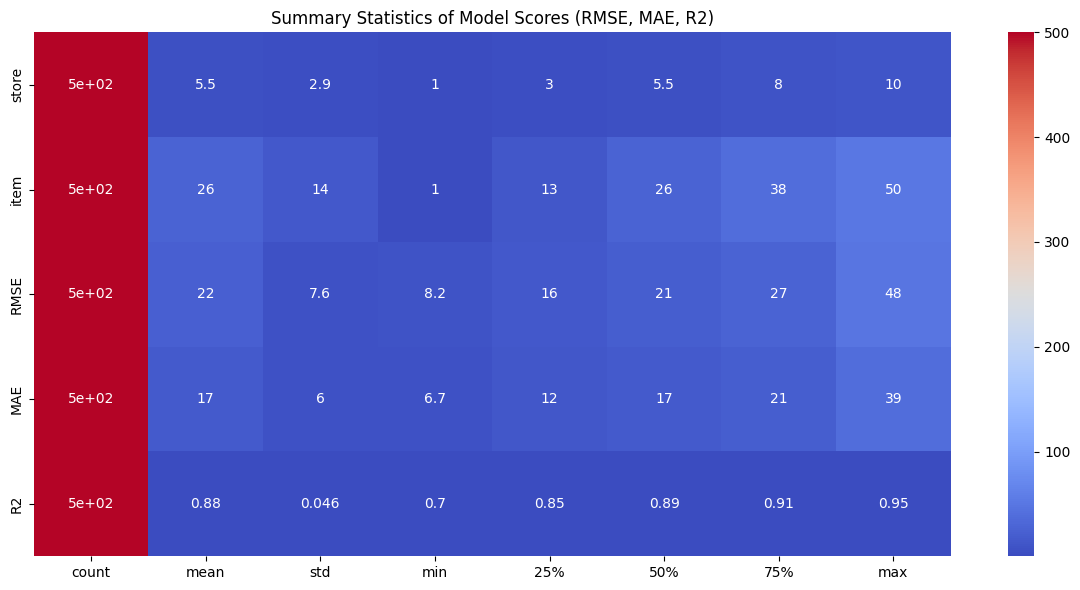

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(scores_7.describe().T, annot=True, cmap="coolwarm", cbar=True, ax=ax)

plt.title("Summary Statistics of Model Scores (RMSE, MAE, R2)")
plt.tight_layout()
plt.show()

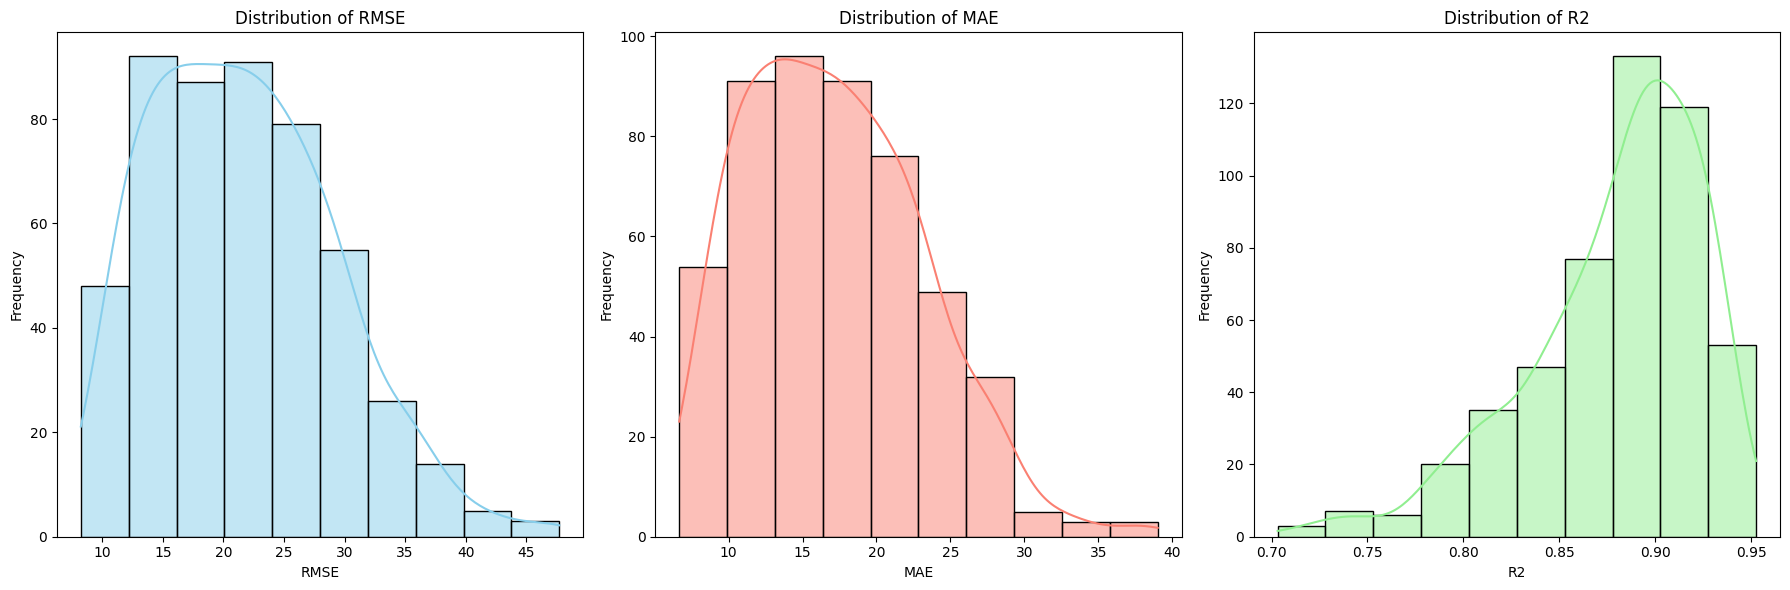

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.histplot(scores_7['RMSE'], bins=10, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Distribution of RMSE')
axes[0].set_xlabel('RMSE')
axes[0].set_ylabel('Frequency')

sns.histplot(scores_7['MAE'], bins=10, kde=True, color='salmon', ax=axes[1])
axes[1].set_title('Distribution of MAE')
axes[1].set_xlabel('MAE')
axes[1].set_ylabel('Frequency')

sns.histplot(scores_7['R2'], bins=10, kde=True, color='lightgreen', ax=axes[2])
axes[2].set_title('Distribution of R2')
axes[2].set_xlabel('R2')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## Training 30 days forecasting models

In [20]:
try:   
    scores_30 = train_models(df.copy(), target_col='target_30_day_sales', model_dir='ml_models/models_30')
except Exception as e:
    print(e)

Items:   0%|          | 0/50 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 889
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 583.598045
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[709]	valid_0's l2: 72.5341
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 917
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 829.463042
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[798]	valid_0's l2: 772.532
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the over

Items:   2%|▏         | 1/50 [00:14<11:55, 14.60s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 983
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 1553.029322
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[838]	valid_0's l2: 307.404
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1016
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 2205.062920
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0

Items:   4%|▍         | 2/50 [00:31<12:49, 16.03s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 933
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 978.160660
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[750]	valid_0's l2: 189.605
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 963
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 1380.538790
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[960]	valid_0's l2: 218.964
[LightGBM] [Info] Auto-choosing col-wise multi-threa

Items:   6%|▌         | 3/50 [00:48<12:47, 16.33s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 880
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 588.123396
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[952]	valid_0's l2: 315.743
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 921
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 830.660965
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[427]	valid_0's l2: 115.146
[LightGBM] [Info] Auto-choosing col-wise multi-thread

Items:   8%|▊         | 4/50 [01:03<12:11, 15.90s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 842
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 489.293830
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[725]	valid_0's l2: 43.6018
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 905
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 691.543067
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[965]	valid_0's l

Items:  10%|█         | 5/50 [01:18<11:39, 15.54s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 979
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 1551.507636
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[996]	valid_0's l2: 446.598
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1023
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 2195.274282
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[776]	valid_0's l2: 801.858
[LightGBM] [Info] Auto-choosing col-wise multi-thr

Items:  12%|█▏        | 6/50 [01:34<11:29, 15.66s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 980
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 1549.191814
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[996]	valid_0's l2: 200.652
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1014
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 2200.237019
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[823]	valid_0's l2: 1672.18
[LightGBM] [Info] Auto-choosing col-wise multi-thr

Items:  14%|█▍        | 7/50 [01:52<11:44, 16.39s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1000
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 2033.948687
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[732]	valid_0's l2: 438.696
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1065
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 2903.697618
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[825]	valid_0's l2: 725.914
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the 

Items:  16%|█▌        | 8/50 [02:10<11:48, 16.88s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 963
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 1368.496640
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[886]	valid_0's l2: 1583.57
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 998
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 1926.472816
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[716]	valid_0's l2: 452.994
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the ov

Items:  18%|█▊        | 9/50 [02:26<11:19, 16.58s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1002
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 1940.277947
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[832]	valid_0's l2: 1970.02
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1049
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 2753.884545
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[992]	valid_0's l2: 2557.79
[LightGBM] [Info] Auto-choosing col-wise multi-th

Items:  20%|██        | 10/50 [02:43<11:11, 16.78s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 992
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 1851.700061
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[712]	valid_0's l2: 2710.28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1048
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 2616.629200
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[906]	valid_0'

Items:  22%|██▏       | 11/50 [03:00<10:57, 16.86s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 994
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 1851.334148
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[930]	valid_0's l2: 6106.39
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1052
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 2619.864997
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[

Items:  24%|██▍       | 12/50 [03:17<10:48, 17.08s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1018
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 2231.611484
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[983]	valid_0's l2: 4915.19
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1088
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 3162.686011
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 5590.49
[LightGBM] [Info] Auto-choosing col-

Items:  26%|██▌       | 13/50 [03:36<10:44, 17.42s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 976
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 1560.062920
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[996]	valid_0's l2: 2652.2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1013
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 2212.193647
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[9

Items:  28%|██▊       | 14/50 [03:51<10:08, 16.91s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1028
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 2332.103849
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[989]	valid_0's l2: 678.236
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1087
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 3295.871717
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:


Items:  30%|███       | 15/50 [04:09<09:56, 17.05s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 897
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 691.510690
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[754]	valid_0's l2: 397.597
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 933
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 975.052535
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[742]	valid_0's l2: 580.222
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the over

Items:  32%|███▏      | 16/50 [04:25<09:31, 16.80s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 924
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 880.180819
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[869]	valid_0's l2: 112.549
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 956
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 1247.693341
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[829]	valid_0's l2: 277.333
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the ove

Items:  34%|███▍      | 17/50 [04:40<08:54, 16.20s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1028
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 2231.401955
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[853]	valid_0's l2: 2188.45
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1075
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 3153.544899
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[954]	valid_0

Items:  36%|███▌      | 18/50 [04:59<09:06, 17.09s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 944
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 1078.441051
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[693]	valid_0's l2: 1139.17
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 972
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 1528.293830
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[963]	valid_0's l2: 638.606
[LightGBM] [Info] Auto-choosing col-wise multi-thre

Items:  38%|███▊      | 19/50 [05:16<08:48, 17.04s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 954
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 1258.232132
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[774]	valid_0's l2: 550.412
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 991
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 1787.406842
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[920]	valid_0's l2: 1009.86
[LightGBM] [Info] Auto-choosing col-wise multi-thre

Items:  40%|████      | 20/50 [05:32<08:26, 16.89s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 942
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 1060.255345
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 985.112
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 978
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 1517.830177
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[815]	valid_0's l2: 691.025
[LightGBM] [Info] Auto-choosing col-wise multi-thr

Items:  42%|████▏     | 21/50 [05:50<08:14, 17.04s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1016
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 2129.609041
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[920]	valid_0's l2: 4452.15
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1070
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 3013.967013
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[919]	valid_0's l2: 3066.07
[LightGBM] [Info] Auto-choosing col-

Items:  44%|████▍     | 22/50 [06:07<07:57, 17.05s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 917
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 780.640806
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[994]	valid_0's l2: 881.956
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 944
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 1108.038485
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[820]	valid_0's l2: 1570.61
[LightGBM] [Info] Auto-choosing col-wise multi-threa

Items:  46%|████▌     | 23/50 [06:25<07:45, 17.24s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 1758.389737
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[890]	valid_0's l2: 1037.83
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1042
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 2478.919976
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 632.151
[LightGBM] [Info] Auto-choosing col-wise multi-th

Items:  48%|████▊     | 24/50 [06:42<07:27, 17.21s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1016
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 2129.945021
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[702]	valid_0's l2: 1562.95
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1078
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 3032.138668
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[986]	valid_0's l2: 1069.31
[LightGBM] [Info] Auto-choosing col-wise multi-th

Items:  50%|█████     | 25/50 [07:01<07:24, 17.77s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 1269.942578
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[580]	valid_0's l2: 199.258
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 994
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 1797.642639
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 1416.66
[LightGBM] [Info] Auto-choosing col-wise multi-thre

Items:  52%|█████▏    | 26/50 [07:17<06:53, 17.25s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 870
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 591.642639
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 121.057
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 921
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 834.656689
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[949]	valid_0's l2: 994.93
[LightGBM] [Info] Auto-choosing col-wise

Items:  54%|█████▍    | 27/50 [07:33<06:31, 17.04s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1024
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 2324.693341
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[929]	valid_0's l2: 4177.84
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1086
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 3291.848503
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:


Items:  56%|█████▌    | 28/50 [07:50<06:12, 16.94s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 994
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 1850.441051
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[802]	valid_0's l2: 1552.3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1040
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 2611.255956
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[995]	valid_0's l2: 2630.64
[LightGBM] [Info] Auto-choosing col-wise multi-thre

Items:  58%|█████▊    | 29/50 [08:11<06:19, 18.07s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 941
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 1065.875382
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[981]	valid_0's l2: 1809.07
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 973
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 1524.806353
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[731]	valid_0's l2: 529.036
[LightGBM] [Info] Auto-choosing col-wise multi-thre

Items:  60%|██████    | 30/50 [08:28<05:54, 17.73s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 973
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 1550.479536
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[998]	valid_0's l2: 952.018
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 2203.786194
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[890]	valid_0's l2: 1228.15
[LightGBM] [Info] Auto-choosing col-wise multi-thr

Items:  62%|██████▏   | 31/50 [08:45<05:31, 17.45s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 947
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 1169.290165
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[867]	valid_0's l2: 258.849
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 980
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 1663.486866
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[995]	valid_0's l2: 804.324
[LightGBM] [Info] Auto-choosing col-wise multi-thre

Items:  64%|██████▍   | 32/50 [09:04<05:24, 18.00s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 996
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 1835.279169
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[996]	valid_0's l2: 2653.57
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1047
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 2616.984117
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 1046.79
[LightGBM] [Info] Auto-choosing col-

Items:  66%|██████▌   | 33/50 [09:21<05:00, 17.70s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 902
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 687.128283
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[854]	valid_0's l2: 197.132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 927
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 973.785583
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's 

Items:  68%|██████▊   | 34/50 [09:35<04:28, 16.77s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 987
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 1740.603543
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[898]	valid_0's l2: 379.093
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1036
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 2474.639585
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 2339.15
[LightGBM] [Info] Auto-choosing col-wise multi-th

Items:  70%|███████   | 35/50 [09:52<04:12, 16.83s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1010
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 2032.401955
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[864]	valid_0's l2: 1257.07
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1062
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 2895.007941
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[990]	valid_0's l2: 3577.86
[LightGBM] [Info] Auto-choosing col-wise multi-th

Items:  72%|███████▏  | 36/50 [10:08<03:51, 16.56s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 907
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 778.741600
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[747]	valid_0's l2: 318.72
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 1103.304826
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[946]	valid_0's l2: 135.229
[LightGBM] [Info] Auto-choosing col-wise multi-thread

Items:  74%|███████▍  | 37/50 [10:24<03:31, 16.28s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1017
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 2144.249847
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 855.089
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1067
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 3017.406231
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:


Items:  76%|███████▌  | 38/50 [10:49<03:46, 18.92s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 947
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 1167.557117
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[900]	valid_0's l2: 1349.16
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 982
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 1656.191814
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[802]	valid_0's l2: 1570.43


Items:  78%|███████▊  | 39/50 [11:10<03:35, 19.63s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 913
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 777.635919
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[996]	valid_0's l2: 513.175
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 942
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 1103.957239
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's l2: 798.188
[LightGBM] [Info] Auto-choosing col-wis

Items:  80%|████████  | 40/50 [11:30<03:15, 19.51s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 865
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 588.365913
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 240.761
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 915
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 822.094685
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[715]	valid_0's l2: 1305.99
[LightGBM] [Info] Auto-choosing row-wise multi-thread

Items:  82%|████████▏ | 41/50 [11:58<03:20, 22.32s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 932
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 970.956017
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 131.171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 968
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 1388.267563
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[968]	valid_0's l2: 207.066
[LightGBM] [Info] Auto-choosing row-wi

Items:  84%|████████▍ | 42/50 [12:21<02:58, 22.36s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 963
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 1353.205864
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 1938.59
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 998
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 1927.998167
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[

Items:  86%|████████▌ | 43/50 [12:40<02:30, 21.44s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 918
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 779.133170
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l2: 922.886
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 942
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 1111.049481
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[788]	valid_0's 

Items:  88%|████████▊ | 44/50 [12:56<01:58, 19.78s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1016
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 2129.259010
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[984]	valid_0's l2: 1029.59
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1066
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 3022.458155
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[827]	valid_0

Items:  90%|█████████ | 45/50 [13:15<01:36, 19.40s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 977
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 1550.765425
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[939]	valid_0's l2: 1308.44
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 2208.425779
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[906]	valid_0's l2: 2175.74
[LightGBM] [Info] Auto-choosing col-w

Items:  92%|█████████▏| 46/50 [13:32<01:14, 18.73s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 888
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 583.252902
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[831]	valid_0's l2: 257.867
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 920
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 833.944411
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[428]	valid_0's l2: 119.127
[L

Items:  94%|█████████▍| 47/50 [13:46<00:52, 17.39s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 963
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 1360.830177
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[800]	valid_0's l2: 1730.88
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1004
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 1930.165547
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[825]	valid_0's l2: 1171.82
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the o

Items:  96%|█████████▌| 48/50 [14:02<00:34, 17.03s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 911
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 777.917532
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[771]	valid_0's l2: 393.635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 948
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 1109.569334
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[779]	valid_0's l2: 389.001
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the ove

Items:  98%|█████████▊| 49/50 [14:19<00:17, 17.01s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 989
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 1736.498473
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[835]	valid_0's l2: 2241.21
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1040
[LightGBM] [Info] Number of data points in the train set: 1637, number of used features: 11
[LightGBM] [Info] Start training from score 2475.962737
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l2: 645.404
[LightGBM] [Info] Auto-choosing col-wise multi-th

Items: 100%|██████████| 50/50 [14:37<00:00, 17.55s/it]


In [21]:
print(scores_30.describe())

            store        item        RMSE         MAE          R2
count  500.000000  500.000000  500.000000  500.000000  500.000000
mean     5.500000   25.500000   32.694055   20.761215    0.975931
std      2.875158   14.445322   19.770168   10.695518    0.020621
min      1.000000    1.000000    6.563835    5.058340    0.836224
25%      3.000000   13.000000   17.371218   12.558855    0.966826
50%      5.500000   25.500000   27.952692   18.566313    0.982670
75%      8.000000   38.000000   44.266297   26.894630    0.990446
max     10.000000   50.000000  139.571104   80.168802    0.997307


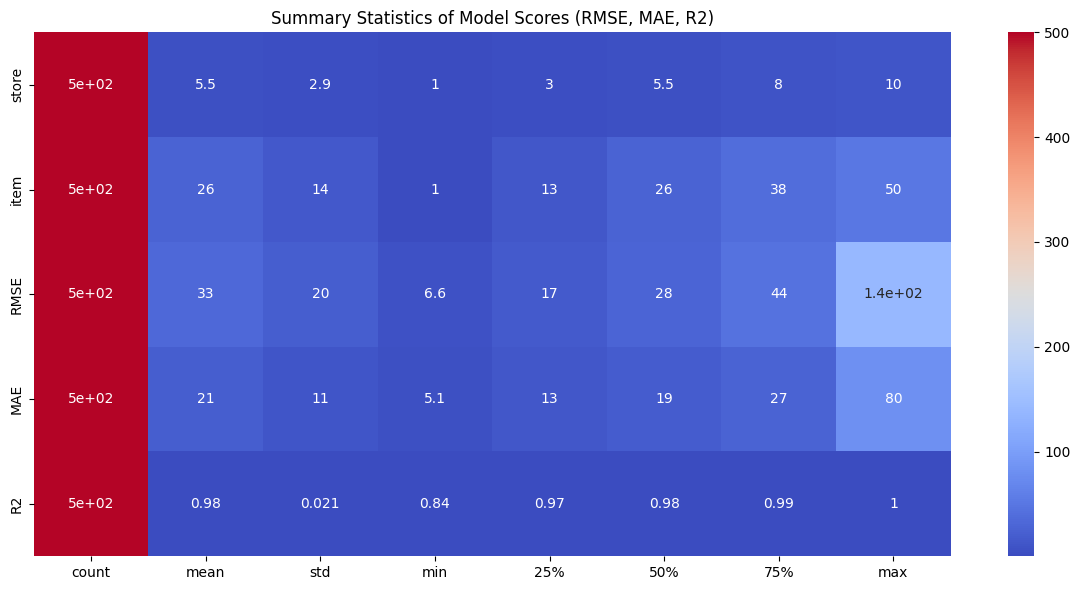

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(scores_30.describe().T, annot=True, cmap="coolwarm", cbar=True, ax=ax)

plt.title("Summary Statistics of Model Scores (RMSE, MAE, R2)")
plt.tight_layout()
plt.show()

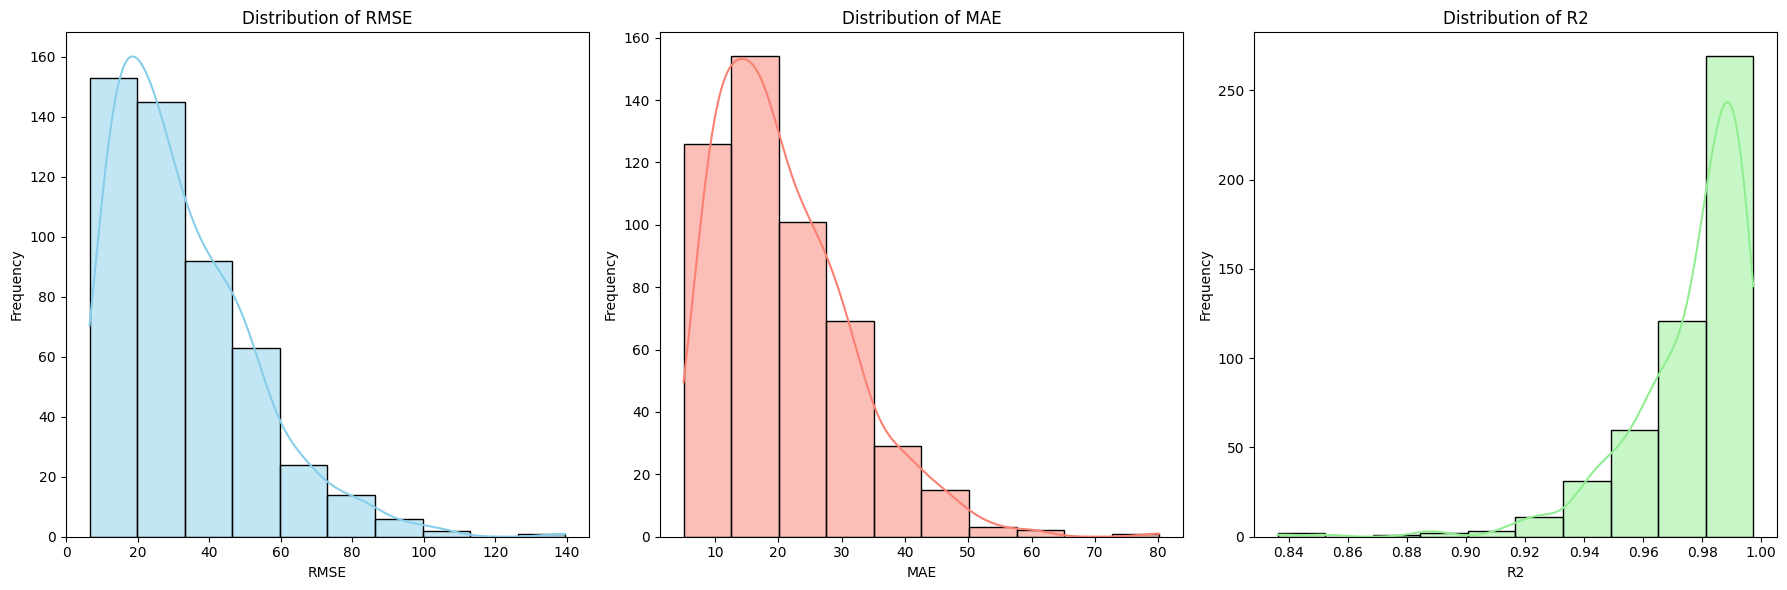

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.histplot(scores_30['RMSE'], bins=10, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Distribution of RMSE')
axes[0].set_xlabel('RMSE')
axes[0].set_ylabel('Frequency')

sns.histplot(scores_30['MAE'], bins=10, kde=True, color='salmon', ax=axes[1])
axes[1].set_title('Distribution of MAE')
axes[1].set_xlabel('MAE')
axes[1].set_ylabel('Frequency')

sns.histplot(scores_30['R2'], bins=10, kde=True, color='lightgreen', ax=axes[2])
axes[2].set_title('Distribution of R2')
axes[2].set_xlabel('R2')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


## Forecasting function for 7 and 30 days respectively

In [31]:
def forecast_future_7(df, target_col, forecast_days=30, model_dir='ml_models/models_7'):
    df = add_sales_timeseries_metrics(df)
    df = add_date_features(df)

    features = [
        'sales_1_day_ago', 'sales_7_days_ago', 'rolling_14_day_sales',
        'rolling_28_day_sales', 'mean_sales', 'day', 'month', 'year',
        'day_of_week', 'weekend', 'quarter'
    ]

    results = []
    items = df['item'].unique()
    stores = df['store'].unique()

    for item_id in tqdm(items, desc="Forecast Items"):
        for store_id in stores:
            df_is = df[(df['item'] == item_id) & (df['store'] == store_id)].copy()
            df_is = df_is.dropna(subset=features)

            if df_is.shape[0] < forecast_days:
                continue

            X_forecast = df_is[features].tail(forecast_days)
            model_path = os.path.join(model_dir, f"{store_id}_{item_id}_{target_col}.pkl")

            if os.path.exists(model_path):
                model = joblib.load(model_path)
                preds = model.predict(X_forecast)
                total_prediction = preds.sum()

                results.append({
                    'store': store_id,
                    'item': item_id,
                    f'total_{forecast_days}_days_prediction': total_prediction
                })
            else:
                print(f"Model missing for Store {store_id}, Item {item_id}")

    return pd.DataFrame(results)


In [32]:
# 30 days 


def forecast_future_30(df, target_col, forecast_days=30, model_dir='ml_models/models_30'):
    df = add_sales_timeseries_metrics(df)
    df = add_date_features(df)

    features = [
        'sales_1_day_ago', 'sales_7_days_ago', 'rolling_14_day_sales',
        'rolling_28_day_sales', 'mean_sales', 'day', 'month', 'year',
        'day_of_week', 'weekend', 'quarter'
    ]

    total_results = []  # This will store the total forecast for each item
    items = df['item'].unique()
    stores = df['store'].unique()

    for item_id in tqdm(items, desc="Forecast Items"):
        item_total_forecast = 0  # Initialize total sum for this item across all stores

        for store_id in stores:
            df_is = df[(df['item'] == item_id) & (df['store'] == store_id)].copy()
            df_is = df_is.dropna(subset=features)

            if df_is.shape[0] < forecast_days:
                continue

            X_forecast = df_is[features].tail(forecast_days)

            model_path = os.path.join(model_dir, f"{store_id}_{item_id}_{target_col}.pkl")
            if os.path.exists(model_path):
                model = joblib.load(model_path)
                preds = model.predict(X_forecast)

                # Sum the predictions for this store for the next 30 days
                item_total_forecast += preds.sum()  # Summing up forecasted sales

            else:
                print(f"Model missing for Store {store_id}, Item {item_id}")

        # After processing all stores for this item, store the total forecasted sales
        total_results.append({
            'item': item_id,
            'total_predicted_sales': item_total_forecast
        })

    # Convert the result list into a DataFrame
    return pd.DataFrame(total_results)


## Creating dummy data for validation 

In [33]:
n_stores = 10
n_items = 50
start_date = '2017-01-01'
end_date = '2018-12-31'

dates = pd.date_range(start=start_date, end=end_date)

data = []

for store in range(1, n_stores + 1):
    for item in range(1, n_items + 1):
        sales = np.random.poisson(lam=np.random.randint(20, 50), size=len(dates))
        seasonal_factor = 10 * np.sin(np.linspace(0, 3*np.pi, len(dates)))

        sales = sales + seasonal_factor + np.random.normal(0, 5, len(dates))
        sales = np.maximum(0, sales).astype(int)

        for i in range(len(dates)):
            data.append([store, item, dates[i], sales[i]])


df_dummy = pd.DataFrame(data, columns=['store', 'item', 'date', 'sales'])



df_dummy.head(1)


,store,item,date,sales
0,1,1,2017-01-01,45


## Forecasting on 7 days 

In [34]:
print("\nForecasting 7 days ahead...")
forecast_7d = forecast_future_7(df_dummy, forecast_days=7, target_col='target_7_day_sales')


Forecasting 7 days ahead...


Forecast Items: 100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


In [35]:
forecast_7d.head(1)

,store,item,total_7_days_prediction
0,1,1,1374.983467


## prediction on 30 days 

In [36]:
  print("\nForecasting 30 days ahead...")
  forecast_30d = forecast_future_30(df_dummy, forecast_days=30, target_col='target_30_day_sales')


Forecasting 30 days ahead...


Forecast Items: 100%|██████████| 50/50 [01:02<00:00,  1.24s/it]


In [38]:
forecast_30d.head(3)

,item,total_predicted_sales
0,1,266021.412983
1,2,364918.880383
2,3,353646.966747
